In [1]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2023-02-26 18:32:51--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.171.40, 52.217.14.214, 52.217.138.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.171.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

replace Cat_Dog_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.applications import vgg16 as vgg
from keras import *
from keras.layers import *
import matplotlib.pyplot as plt
import os

In [3]:
base_dir = 'Cat_Dog_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   zoom_range=0.1,
                                   rotation_range=1)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
LABEL_DICT={1:'dog',0:'cat'}

In [6]:
def define_model():
  model = Sequential()

  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
  return model

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [8]:
vgg_model = vgg.VGG16(weights='imagenet', 
                       include_top=False)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
last = vgg_model.get_layer('block5_pool').output

In [10]:
# Добавим новые GAP (вместо FLatten) и BatchNormalization слои
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)

# Привычные полносвязные слои
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(1, activation='sigmoid')(x)

In [11]:
fin_model = Model(vgg_model.input, pred)

In [12]:
for layer in vgg_model.layers[0:15]:
    layer.trainable = False

In [13]:
fin_model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
fin_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [14]:
history_cnn = fin_model.fit_generator(train_generator,
              epochs=5,
              validation_data=test_generator,
              shuffle=True)

<ipython-input-14-2721f4275d75>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn = fin_model.fit_generator(train_generator,


Epoch 1/5
176/176 [==============================] - 349s 2s/step - loss: 0.1845 - accuracy: 0.9217 - val_loss: 0.8034 - val_accuracy: 0.7876
Epoch 2/5
176/176 [==============================] - 323s 2s/step - loss: 0.1109 - accuracy: 0.9559 - val_loss: 0.0934 - val_accuracy: 0.9636
Epoch 3/5
176/176 [==============================] - 323s 2s/step - loss: 0.0877 - accuracy: 0.9660 - val_loss: 0.0904 - val_accuracy: 0.9652
Epoch 4/5
176/176 [==============================] - 323s 2s/step - loss: 0.0751 - accuracy: 0.9715 - val_loss: 0.1672 - val_accuracy: 0.9396
Epoch 5/5
176/176 [==============================] - 323s 2s/step - loss: 0.0672 - accuracy: 0.9739 - val_loss: 0.0786 - val_accuracy: 0.9660


20/20 [==============================] - 12s 584ms/step - loss: 0.0786 - accuracy: 0.9660


[0.07860077172517776, 0.9660000205039978]

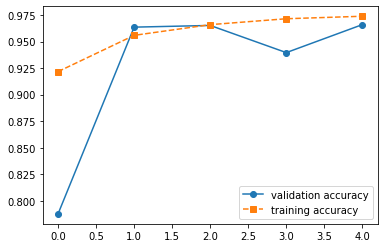

In [15]:
plt.plot(history_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();
fin_model.evaluate(test_generator)